In [8]:
import pandas as pd
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from string import punctuation
import numpy as np
import re

In [11]:
tweets = pd.read_json('/Users/sam/Documents/Masters/Data_Systems_Project/Locations/user_locations.json')

In [ ]:
tweets = tweets[tweets['state']=='CA']
tweets = tweets[tweets.text.str.contains('RT ')==False]

### cleaning

In [12]:
#clear hyperlinks
def clean_hyperlinks(text):
    result = re.sub(r'https?://[^\s<>"]+|www\.[^\s<>"]+'," ", str(text))
    #result = text.replace("RT ", "")
    return result

tweets['text'] = tweets['text'].apply(clean_hyperlinks)

#take out hashtags and mentions
def string_manipulation(df,column):
    df["hashtag"]  = df[column].str.findall(r'#.*?(?=\s|$)')
    df["accounts"] = df[column].str.findall(r'@.*?(?=\s|$)')
    return df
tweets = string_manipulation(tweets,"text")
#make list of al hashtags found
tweets['hashtag']=tweets['hashtag'].apply(str)
tweets['hashtag'] = tweets['hashtag'].apply(lambda x: ','.join(map(str, x)))

#take out hashtags sign and make everything lowercase
def inlist(text): 
    result = text.replace("#", "")
    result = result.lower()
    result = text.split(",")
    return result
tweets['hashtag'] = tweets['hashtag'].apply(inlist)

#make list of tweets
list_of_tweets = []
for tweet in tweets['text']:
    temp = tweet
    list_of_tweets.append(temp)

# Create a set of stopwords
stop = set(stopwords.words('english'))

# Create a set of punctuation words 
exclude = set(string.punctuation) 

# This is the function makeing the lemmatization
lemma = WordNetLemmatizer()

# In this function we perform the entire cleaning
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# This is the clean corpus.
tweets['token'] = [clean(doc).split() for doc in list_of_tweets]

In [58]:
def split(x):
    x = str(x).split()[0]
    return x
tweets['created_at'] = tweets['created_at'].map(split)
tweets['created_at'] = pd.to_datetime(tweets['created_at'], format="%Y-%m-%d")

In [ ]:
splitted=tweets["user_location"].str.split(", ", n = 1, expand = True)
tweets["state"] = splitted[1]
tweets["city"] = splitted[0]
del splitted

### LDA

In [37]:
# Importing Gensim
import gensim
from gensim import corpora

#Tokens
#tokens = tweets['token']

# Creating the term dictionary of our courpus, where every unique term is assigned an index
dictionary = gensim.corpora.Dictionary(tweets['token'])

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(tweet) for tweet in tweets['token']]

In [48]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=2, id2word = dictionary, passes=5)

In [56]:
# Print 2 topics and describe then with 4 words.
topics = ldamodel.print_topics(num_topics=2, num_words=5)

i=0
for topic in topics:
    print ("Topic",i ,"->", topic)
    i+=1

Topic 0 -> (0, '0.091*"blacklivesmatter" + 0.016*"blm" + 0.009*"georgefloyd" + 0.008*"protest" + 0.006*"defundthepolice"')
Topic 1 -> (1, '0.041*"blacklivesmatter" + 0.014*"black" + 0.009*"amp" + 0.008*"people" + 0.007*"police"')


In [93]:
states = np.unique(tweets.state)
dates = np.unique(tweets.created_at)

tweets['topic1'] = 0
tweets['topics2'] = 0

for state in states:
    for date in dates:
        temp = tweets.loc[(tweets['state']==state) & (tweets['created_at']== date)]

        doc_term_matrix = [dictionary.doc2bow(tweet) for tweet in temp['token']]

        ldamodel = Lda(doc_term_matrix, num_topics=2, id2word = dictionary, passes=5)

        topics = ldamodel.print_topics(num_topics=2, num_words=5)

        tweets['topic1'].loc[(tweets['state']==state) & (tweets['created_at']== date)] = re.findall('"([^"]*)"', topics[0][1])
        tweets['topic2'].loc[(tweets['state']==state) & (tweets['created_at']== date)] = re.findall('"([^"]*)"', topics[1][1])

#tweets[['text', 'created_at']].groupby('created_at').head()

In [120]:
def drop_BLM(x):
    output = x[1:]
    return output
tweets['topic1'] = tweets['topic1'].map(drop_BLM)
tweets['topic2'] = tweets['topic2'].map(drop_BLM)

### sentiment analysis


In [106]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(text):
    score = analyser.polarity_scores(text)
    return score['compound']

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sam/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
tweets['sentiment'] = np.nan
tweets['sentiment'] = tweets['text'].apply(sentiment_analyzer_scores)

[Text(0, 0.5, '#Tweets'),
 Text(0.5, 0, 'Negative                Neutral                 Positive'),
 Text(0.5, 1.0, 'Tweets')]

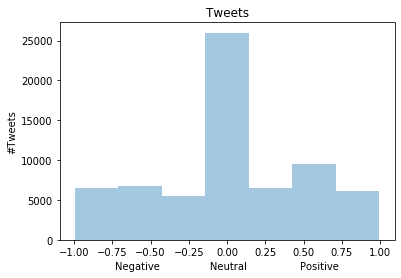

In [109]:
import seaborn as sns
ax = sns.distplot(
        tweets['sentiment'],
        kde=False,
        bins=7)
ax.set(xlabel='Negative                Neutral                 Positive',
           ylabel='#Tweets',
          title="Tweets")

In [122]:
tweets.to_json('date_city_topics.json')

In [123]:
tweets.head()

,created_at,id,text,coordinates,lang,place,user_location,hashtag,accounts,token,state,city,topic2,topic1,topics2,sentiment
169,2020-05-07,1258371211752435712,I’m sick of this. How many more #innocent blac...,None,en,None,"Los Angeles, CA","[[, ', #, i, n, n, o, c, e, n, t, ', , , , ',...",[],"[i’m, sick, this, many, innocent, black, men, ...",CA,Los Angeles,"[black, white, justiceforahmaud, justice]","[justiceforahmaud, tired, can’t, black]",0,-0.9621
247,2020-05-07,1258374109710278656,Praying for #SeanReed and #AhmaudAubrey famil...,None,en,None,"Los Angeles, CA","[[, ', #, S, e, a, n, R, e, e, d, ', , , , ',...",[],"[praying, seanreed, ahmaudaubrey, family, sens...",CA,Los Angeles,"[black, white, justiceforahmaud, justice]","[justiceforahmaud, tired, can’t, black]",0,-0.6369
319,2020-05-07,1258376559632609280,And no....we won’t let it go. \nNo we won’t fo...,None,en,None,"San Diego, CA","[[, ', #, B, l, a, c, k, L, i, v, e, s, M, a, ...",[],"[nowe, won’t, let, go, won’t, forget, won’t, g...",CA,San Diego,"[black, white, justiceforahmaud, justice]","[justiceforahmaud, tired, can’t, black]",0,-0.8591
328,2020-05-07,1258376757322760192,"Tomorrow, 5/8. The running community has the c...",None,en,None,"Oceanside, CA","[[, ', #, I, R, u, n, W, i, t, h, M, a, u, d, ...",[],"[tomorrow, 58, running, community, chance, hon...",CA,Oceanside,"[black, white, justiceforahmaud, justice]","[justiceforahmaud, tired, can’t, black]",0,0.6486
513,2020-05-07,1258382503712260099,"These days, you’ll barely catch me taking a sh...",None,en,None,"Los Angeles, CA","[[, ]]",[],"[day, you’ll, barely, catch, taking, shit, wit...",CA,Los Angeles,"[black, white, justiceforahmaud, justice]","[justiceforahmaud, tired, can’t, black]",0,-0.5574
